In [1]:
import datetime
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import Facebook.Prophet package for data series forecasting
import pystan
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


(1849886, 1)
        y
0    0.00
1  391.59
2  404.71
3  413.77
4  408.04


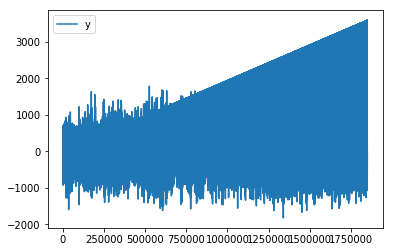

In [2]:
raw_data = pd.read_csv("bl.csv")
raw_data = pd.DataFrame(raw_data.values.flatten())
raw_data.columns = ['y']

print(raw_data.shape)
print(raw_data.head())
raw_data.plot()

In [3]:
#better to apply a scaler
scaler = StandardScaler()
scaler.fit(raw_data['y'].values.reshape([-1, 1]))
raw_data['y'] = scaler.transform(raw_data['y'].values.reshape([-1, 1]))
print(raw_data.shape)
print(raw_data.head())

(1849886, 1)
          y
0 -0.010226
1  1.146448
2  1.185202
3  1.211963
4  1.195038


In [4]:
#will take 1 sampel from each 256 samples. This number is experimental.
data = raw_data[raw_data.index % 256 == 0]
#data = raw_data.iloc[:7227,:]
print(data.shape)


(7227, 1)


In [5]:
#set train and test length
import math
train_len = math.floor((data.shape[0] / 100) * 70)
test_len = data.shape[0] - train_len

In [7]:
print("raw data.shape: ", raw_data.shape, "data.shape: ", data.shape, "train_len: ", train_len, "test_len: ", test_len)

raw data.shape:  (1849886, 1) data.shape:  (7227, 1) train_len:  5058 test_len:  2169


In [8]:
#will create a date-time list to assign it to the forecasted data
date_list = []
start_date = datetime.datetime(2016, 11, 12, 0, 0, 0)
for i in range(data.shape[0] + 1):
    if i > 0:
        new_date = start_date + pd.to_timedelta(i, unit='s')
        date_list.append(new_date)

In [9]:
#set column names to 'ds' and 'y', because these are the names expected by Prophet
data = pd.DataFrame({'ds': date_list, 'y': data.y})
print(data.head())
print(data.tail())

                      ds         y
0    2016-11-12 00:00:01 -0.010226
256  2016-11-12 00:00:02  0.419964
512  2016-11-12 00:00:03  0.091768
768  2016-11-12 00:00:04  0.122293
1024 2016-11-12 00:00:05  0.501370
                         ds         y
1848832 2016-11-12 02:00:23 -0.086463
1849088 2016-11-12 02:00:24 -1.752577
1849344 2016-11-12 02:00:25  0.045485
1849600 2016-11-12 02:00:26  1.807949
1849856 2016-11-12 02:00:27 -1.192864


In [136]:
data.head()

,ds,y
0,2016-11-12 00:00:01,-0.010226
256,2016-11-12 00:00:02,0.419964
512,2016-11-12 00:00:03,0.091768
768,2016-11-12 00:00:04,0.122293
1024,2016-11-12 00:00:05,0.501370


In [10]:
#create some log and diff columns to feed them to Prophet
data['y_diff'] = data['y'] - data['y'].shift(1)
data['y_log'] = np.log(data['y'])
data['y_log_diff'] = data['y_log'] - data['y_log'].shift(1)

data.head()

,ds,y,y_diff,y_log,y_log_diff
0,2016-11-12 00:00:01,-0.010226,NaN,NaN,NaN
256,2016-11-12 00:00:02,0.419964,0.430190,-0.867587,NaN
512,2016-11-12 00:00:03,0.091768,-0.328195,-2.388488,-1.520902
768,2016-11-12 00:00:04,0.122293,0.030524,-2.101338,0.287151
1024,2016-11-12 00:00:05,0.501370,0.379077,-0.690411,1.410927


In [11]:
#replace +-inf and nan with mean()
temp_y_log = data.y_log.replace([np.inf, -np.inf], np.nan)
temp_y_log.dropna(inplace=True)
y_log_mean = temp_y_log.mean()
data['y_log'].replace([np.inf, -np.inf, np.nan], y_log_mean, inplace=True)

temp_y_log_diff = data.y_log_diff.replace([np.inf, -np.inf], np.nan)
temp_y_log_diff.dropna(inplace=True)
y_log_diff_mean = temp_y_log_diff.mean()
data['y_log_diff'].replace([np.inf, -np.inf, np.nan], y_log_diff_mean, inplace=True)

data

,ds,y,y_diff,y_log,y_log_diff
0,2016-11-12 00:00:01,-0.010226,NaN,-0.729949,-0.005479
256,2016-11-12 00:00:02,0.419964,0.430190,-0.867587,-0.005479
512,2016-11-12 00:00:03,0.091768,-0.328195,-2.388488,-1.520902
768,2016-11-12 00:00:04,0.122293,0.030524,-2.101338,0.287151
1024,2016-11-12 00:00:05,0.501370,0.379077,-0.690411,1.410927
1280,2016-11-12 00:00:06,-0.597292,-1.098662,-0.729949,-0.005479
1536,2016-11-12 00:00:07,-0.080801,0.516491,-0.729949,-0.005479
1792,2016-11-12 00:00:08,0.119670,0.200471,-2.123019,-0.005479
2048,2016-11-12 00:00:09,1.709706,1.590036,0.536321,2.659341
2304,2016-11-12 00:00:10,0.553741,-1.155965,-0.591059,-1.127380


In [139]:
print(data.shape)

(7227, 5)


In [15]:
train_data = data.iloc[:train_len,:]
print(train_data.shape)

(5058, 5)


In [16]:
#train_data

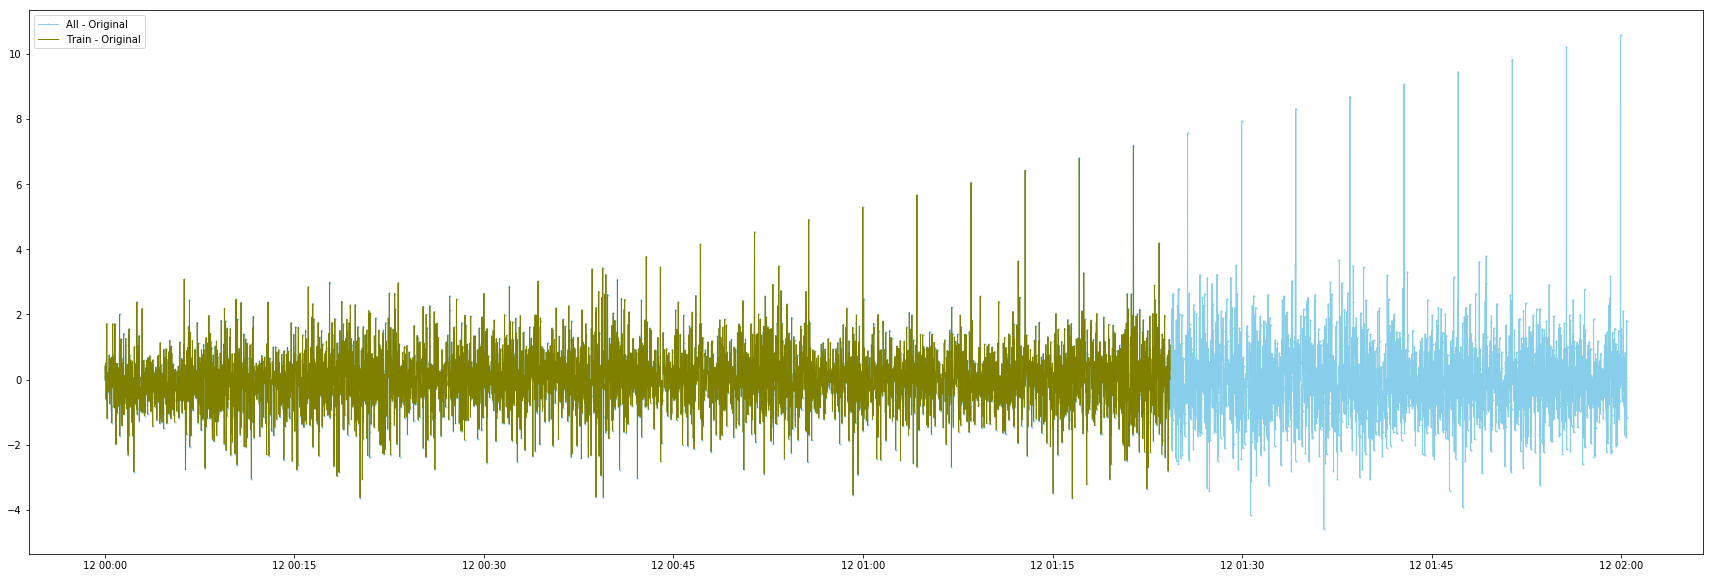

In [17]:
fig = plt.figure(figsize=(30, 10))
plt.plot( 'ds', 'y', label='All - Original', data=data, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=1)
plt.plot( 'ds', 'y', label='Train - Original', data=train_data, marker='', color='olive', linewidth=1)
plt.legend()

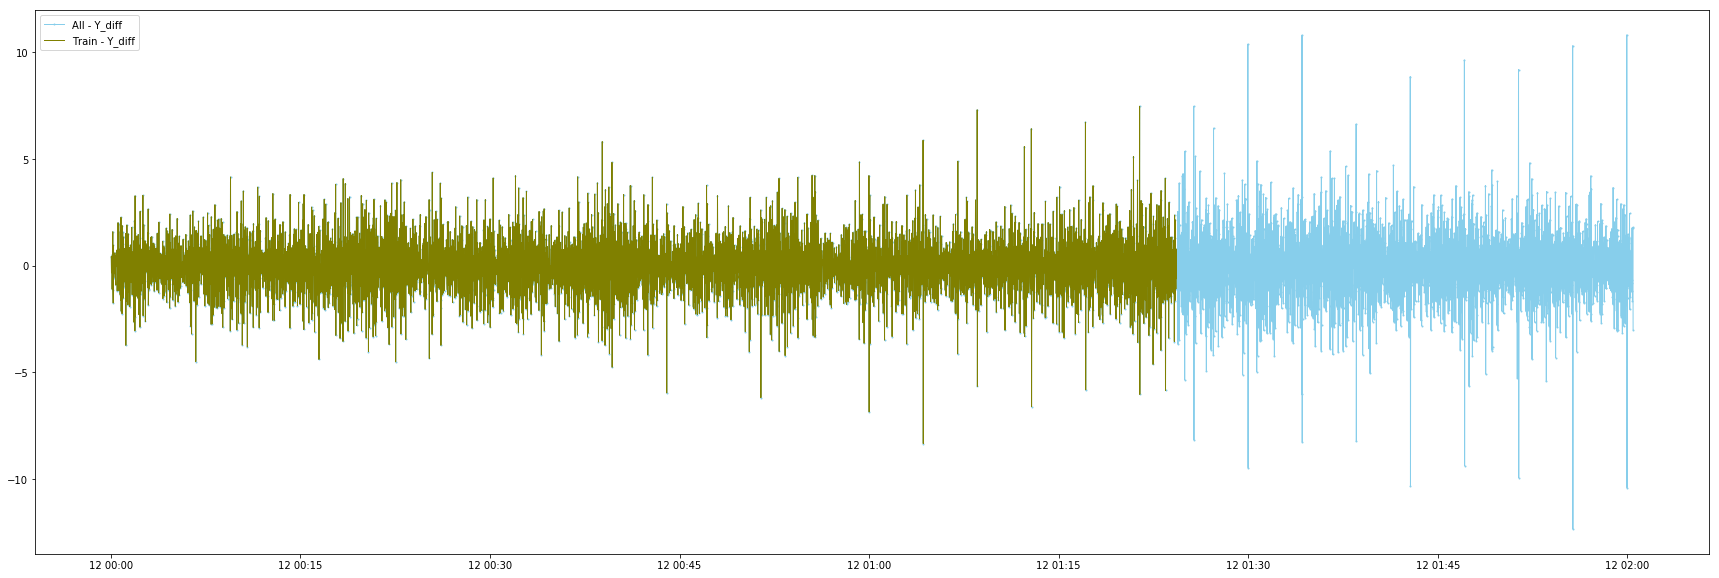

In [18]:
fig = plt.figure(figsize=(30, 10))
plt.plot( 'ds', 'y_diff', label='All - Y_diff', data=data, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=1)
plt.plot( 'ds', 'y_diff', label='Train - Y_diff', data=train_data, marker='', color='olive', linewidth=1)
plt.legend()

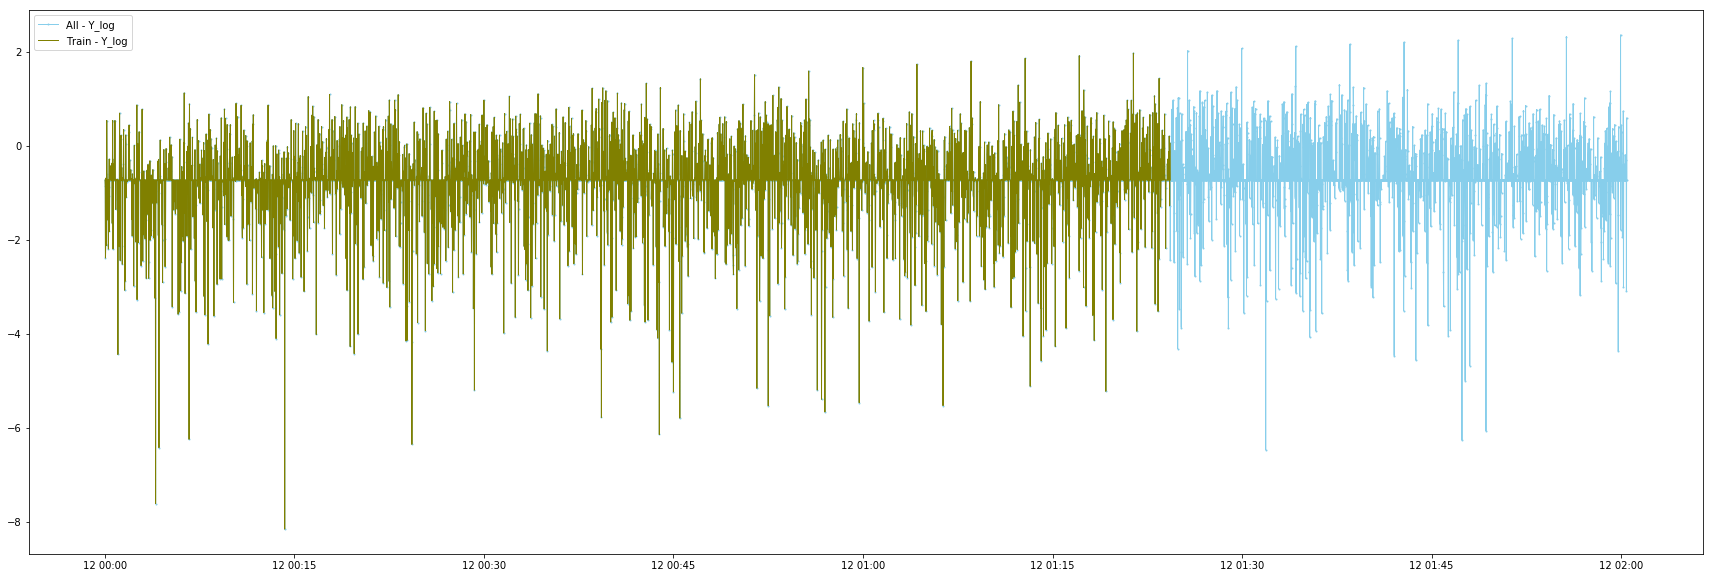

In [19]:
fig = plt.figure(figsize=(30, 10))
plt.plot( 'ds', 'y_log', label='All - Y_log', data=data, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=1)
plt.plot( 'ds', 'y_log', label='Train - Y_log', data=train_data, marker='', color='olive', linewidth=1)
plt.legend()

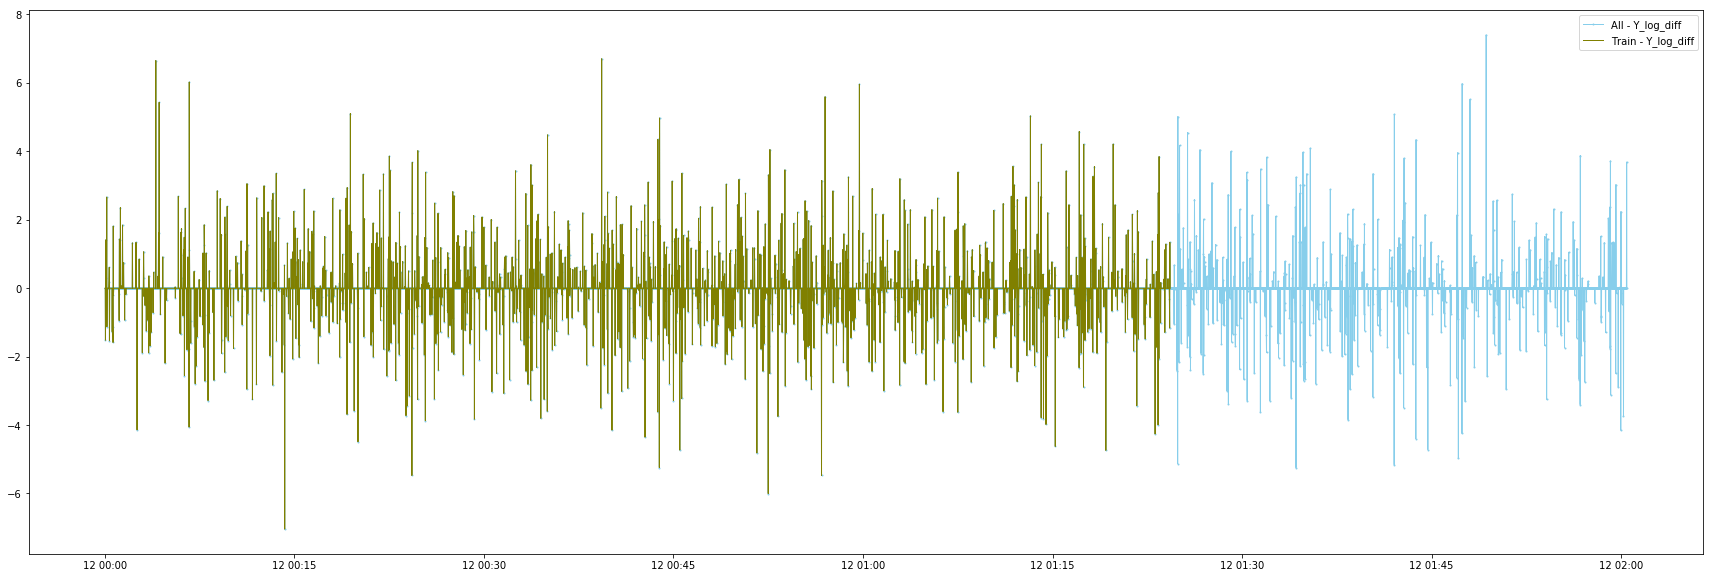

In [20]:
fig = plt.figure(figsize=(30, 10))
plt.plot( 'ds', 'y_log_diff', label='All - Y_log_diff', data=data, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=1)
plt.plot( 'ds', 'y_log_diff', label='Train - Y_log_diff', data=train_data, marker='', color='olive', linewidth=1)
plt.legend()

In [21]:
#HI!

In [22]:
train = train_data[['ds', 'y']]#:P
train = train.rename(columns = {'ds':'ds', 'y': 'y'})
#train

In [23]:
#create test_stationarity function to check if our data is stationay

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).mean()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

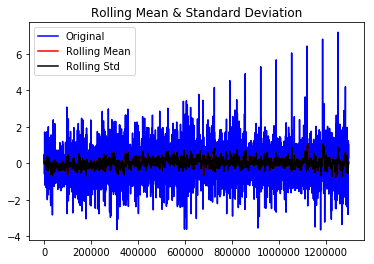

Results of Dickey-Fuller Test:
Test Statistic                  -53.571534
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    5056.000000
Critical Value (10%)             -2.567074
Critical Value (5%)              -2.862112
Critical Value (1%)              -3.431644
dtype: float64


In [24]:
test_stationarity(train.y)

In [151]:
#train

In [25]:
p = Prophet()#seasonality_mode='multiplicative'

p.fit(train)
p.params

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'Y': array([[-0.02307181, -0.02305295, -0.02303409, ...,  0.00157552,
          0.00156938,  0.00156323]]),
 'beta': array([[0.]]),
 'beta_a': array([[0.]]),
 'beta_m': array([[0.]]),
 'delta': array([[ 1.13015876e-07, -2.68697880e-08, -1.54257819e-06,
          2.17822331e-08,  3.12327134e-07,  1.33094460e-07,
         -1.13916491e-07, -2.43738194e-07, -3.47041557e-07,
         -1.42452566e-06, -1.04648640e-03, -2.35092502e-02,
         -3.57816914e-02, -2.80750222e-02, -2.30232956e-02,
         -1.41643930e-02, -2.54030346e-05, -1.11003989e-04,
         -2.83422665e-04, -6.76590532e-05, -8.00504555e-07,
         -8.90768445e-07, -3.69638425e-04, -1.33023661e-08,
         -1.19698596e-07]]),
 'k': array([[0.09537757]]),
 'm': array([[-0.02307181]]),
 'sigma_obs': array([[0.12940218]]),
 'trend': array([[-0.02307181, -0.02305295, -0.02303409, ...,  0.00157552,
          0.00156938,  0.00156323]])}

In [26]:
#forecast
span = data.shape[0] - train.shape[0]
print("Span: ", span)
future = p.make_future_dataframe(periods=span, freq='s', include_history=False)
print(data.shape, train.shape, future.shape)

Span:  2169
(7227, 5) (5058, 2) (2169, 1)


In [27]:
forecasted = p.predict(future)
forecasted
print(forecasted.shape)

(2169, 13)


In [55]:
forecasted

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-11-12 01:24:19,-0.147604,-0.147604,-0.147604,-1.077291,0.698858,0.0,0.0,0.0,0.0,0.0,0.0,-0.147604
1,2016-11-12 01:24:20,-0.147616,-0.147616,-0.147616,-1.136471,0.762252,0.0,0.0,0.0,0.0,0.0,0.0,-0.147616
2,2016-11-12 01:24:21,-0.147629,-0.147629,-0.147629,-1.107725,0.800845,0.0,0.0,0.0,0.0,0.0,0.0,-0.147629
3,2016-11-12 01:24:22,-0.147641,-0.147641,-0.147641,-1.080542,0.762823,0.0,0.0,0.0,0.0,0.0,0.0,-0.147641
4,2016-11-12 01:24:23,-0.147654,-0.147654,-0.147654,-1.059367,0.777766,0.0,0.0,0.0,0.0,0.0,0.0,-0.147654
5,2016-11-12 01:24:24,-0.147666,-0.147666,-0.147666,-1.088771,0.716323,0.0,0.0,0.0,0.0,0.0,0.0,-0.147666
6,2016-11-12 01:24:25,-0.147679,-0.147679,-0.147679,-1.153202,0.792807,0.0,0.0,0.0,0.0,0.0,0.0,-0.147679
7,2016-11-12 01:24:26,-0.147691,-0.147691,-0.147691,-1.085267,0.743411,0.0,0.0,0.0,0.0,0.0,0.0,-0.147691
8,2016-11-12 01:24:27,-0.147704,-0.147704,-0.147704,-1.013353,0.797415,0.0,0.0,0.0,0.0,0.0,0.0,-0.147704
9,2016-11-12 01:24:28,-0.147716,-0.147716,-0.147716,-1.112370,0.736257,0.0,0.0,0.0,0.0,0.0,0.0,-0.147716


In [28]:
forecasted = forecasted.rename(columns={'ds': 'ds', 'yhat': 'y'})
forecasted.ds = pd.to_datetime(forecasted.ds)
print(forecasted.shape)

(2169, 13)


In [29]:
print(data.shape, train_data.shape, forecasted.shape)

(7227, 5) (5058, 5) (2169, 13)


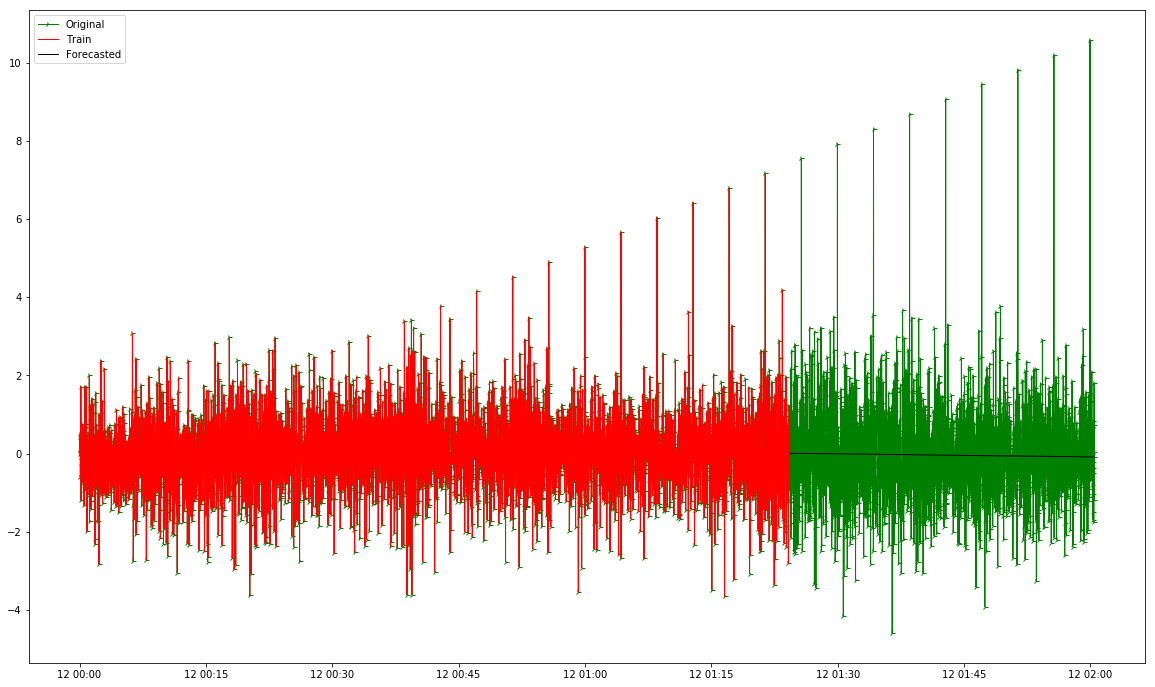

In [31]:
# multiple line plot
plt.figure(figsize=(20, 12))
plt.plot( 'ds', 'y', label='Original', data=data, marker='4', color='green', linewidth=1)#:P
plt.plot( 'ds', 'y', label='Train', data=train, marker='', color='red', linewidth=1)
plt.plot( 'ds', 'y', label='Forecasted', data=forecasted, marker='', color='black', linewidth=1)
plt.legend()


#we notice how bad Prophet was for forecasting brain data (the black horizontal line). That's expected because it's usually used for seasonal data.

# ARIMA

In [32]:
#let's try ARIMA. It should forecast better!

from statsmodels.tsa.arima_model import ARIMA
#from pyramid.arima import auto_arima

df_train, df_test = data.iloc[:train_len,:], data.iloc[train_len:,:]
print(df_train.shape, df_test.shape)

(5058, 5) (2169, 5)


In [34]:
arima = ARIMA(df_train.y.values, dates=date_list, order=(4,1,2))#:P
arima_fitted_model = arima.fit(disp=-1)
start_date = date_list[-test_len]
end_date = date_list[-1]
arima_forecast = arima_fitted_model.predict(start = start_date, end = end_date)
print("Prediction completed.")

C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)
C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency S will be used.
  % freq, ValueWarning)


Prediction completed.


C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [35]:
arima_df_results = pd.DataFrame({'ds': date_list[-arima_forecast.shape[0]:], 'y': arima_forecast})
print(arima_df_results.shape)
arima_df_results.head()
arima_df_results['y'] = arima_df_results['y']# * 3

(2169, 2)


In [36]:
final = arima_df_results.copy()
scaler = StandardScaler()
scaler.fit(final['y'].values.reshape([-1, 1]))
final['y'] = scaler.transform(final['y'].values.reshape([-1, 1]))

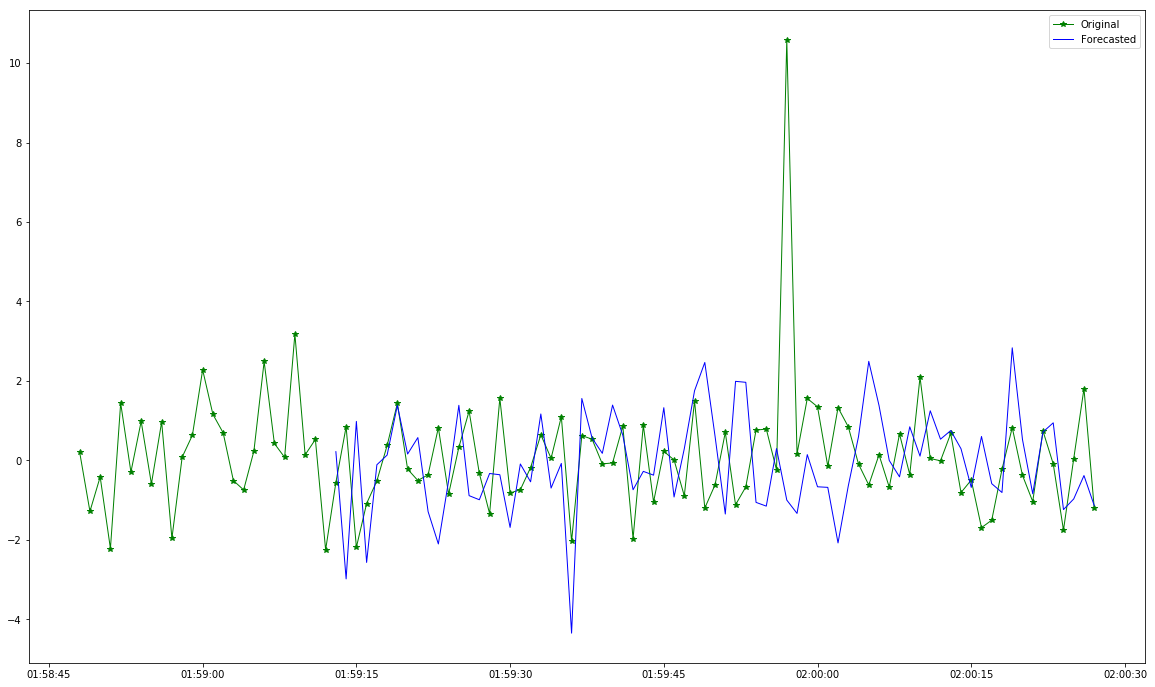

In [37]:
plt.figure(figsize=(20, 12))
plt.plot( 'ds', 'y', label='Original', data=df_test.iloc[-100:,:], marker='*', color='green', linewidth=1)#:P
plt.plot( 'ds', 'y', label='Forecasted', data=final.iloc[-75:,:], marker='', color='blue', linewidth=1)#:P
plt.legend()

In [38]:
#accuracy metrics
from sklearn import metrics

mae = metrics.mean_absolute_error(df_test.y_log.values, arima_df_results.y.values)#:P
mse = metrics.mean_squared_error(df_test.y_log.values, arima_df_results.y.values)#:P
sqrt = np.sqrt(metrics.mean_squared_error(df_test.y_log.values, arima_df_results.y.values))#:P

print("mae: ", mae)
print("mse: ", mse)
print("sqrt: ", sqrt)

mae:  1.1297159580537999
mse:  2.1901033076452836
sqrt:  1.4798997627019486
